# Synopsis

This notebook conatains various simulation scripts for Comparator. The following simulations are included:

1.  Transient Analysis
2.  DC Offset Voltage Analysis
3.  CMRR Analysis
4.  Timing & Speed Analysis
5.  Power Consumption Analysis
6.  Resolution Analysis
7.  Kickback Noise Analysis
8.  PVT Corner Analysis

The scripts are meant to be run on the host machine running Container iic-osic-tools_shell_uid_501.

Start the container with the start_shell.sh script in the iic-osic-tools repo.
```
    cd <IIC_OSIC_TOOLS_PATH>
    ./start_shell.sh
```

# Dependencies

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
from spyci import spyci

# Environment Variables

In [3]:
%%bash
# Set variables

export PDK_LIB_FILE=/foss/pdks/sky130A/libs.tech/combined/sky130.lib.spice
export WORK_DIR=/foss/designs
export REPO_DIR=$WORK_DIR/tt10-fp-adc8
export XSCHEM_DIR=$REPO_DIR/xschem
export SIM_DIR=$XSCHEM_DIR/sample
export DC_SWEEP_SIM_FILE=$SIM_DIR/dc_sweep.sp
export TESTBENCH_FILE=$XSCHEM_DIR/dc_sweep.sp
export SPICE_FILE=a$XSCHEM_DIR/dc_comp_circuit.spice


In [ ]:
# # Set variables
# os.environ['DC_SWEEP_SIM_FILE'] = 'dc_sweep.sp'
# os.environ['SIM_DIR'] = 'tt10-fp-adc8/xschem/simulation/'
# os.environ['PDK_LIB_FILE'] = '/foss/pdks/sky130A/libs.tech/combined/sky130.lib.spice'
# os.environ['TESTBENCH_FILE'] = 'dc_sweep.sp'
# os.environ['SPICE_FILE'] = 'adc_comp_circuit.spice'

In [4]:
# Set variables
os.environ['PDK_LIB_FILE'] = '/foss/pdks/sky130A/libs.tech/combined/sky130.lib.spice'
os.environ['WORK_DIR'] = '/foss/designs'
os.environ['REPO_DIR'] = os.path.join(os.environ['WORK_DIR'], 'tt10-fp-adc8')
os.environ['XSCHEM_DIR'] = os.path.join(os.environ['REPO_DIR'], 'xschem')
os.environ['SIM_DIR'] = os.path.join(os.environ['XSCHEM_DIR'], 'simulation')
os.environ['DC_SWEEP_SIM_FILE'] = os.path.join(os.environ['SIM_DIR'], 'dc_sweep.sp')
os.environ['TESTBENCH_FILE'] = os.path.join(os.environ['XSCHEM_DIR'], 'dc_sweep.sp')
os.environ['SPICE_FILE'] = os.path.join(os.environ['XSCHEM_DIR'], 'dc_comp_circuit.spice')

# Utils

In [5]:
# Run outside container
def run_ngspice(spice_file):
    """Run ngspice simulation in the OSIC container"""
    container_name = f"iic-osic-tools_shell_uid_{os.getuid()}"
    ngspice_path = "/foss/tools/bin/ngspice"
    
    !docker exec {container_name} {ngspice_path} -b {spice_file}

# example usage
# run_ngspice("tt10-fp-adc8/xschem/simulation/strongArmLatch_tb.spice")

# Transient Analysis

## Generate TB File

In [6]:
# Set variables
os.environ['PDK_LIB_FILE'] = '/foss/pdks/sky130A/libs.tech/combined/sky130.lib.spice'
os.environ['WORK_DIR'] = '/foss/designs'
os.environ['REPO_DIR'] = os.path.join(os.environ['WORK_DIR'], 'tt10-fp-adc8')
os.environ['XSCHEM_DIR'] = os.path.join(os.environ['REPO_DIR'], 'xschem')
os.environ['SIM_DIR'] = os.path.join(os.environ['XSCHEM_DIR'], 'simulation')
os.environ['DC_SWEEP_SIM_FILE'] = os.path.join(os.environ['SIM_DIR'], 'dc_sweep.sp')
# os.environ['TRAN_SIM_FILE'] = os.path.join(os.environ['SIM_DIR'], 'tran.sp')
os.environ['TRAN_SIM_FILE'] = 'tran.sp'
os.environ['TESTBENCH_FILE'] = os.path.join(os.environ['SIM_DIR'], 'tran.sp')
os.environ['SPICE_FILE'] = os.path.join(os.environ['SIM_DIR'], 'comparator.spice')

In [10]:
%%bash
cat << EOF > ${TRAN_SIM_FILE}
* Simple DC Sweep Analysis for SKY130 Strongarm Latch / Comparator
* Including the comparator subcircuit
.include ${SPICE_FILE}

* Model files - replace with actual SKY130 PDK path for proper simulation
.lib ${PDK_LIB_FILE} tt

* Simulation parameters
V1 VDD GND 1.8
V2 clk GND 0 PULSE(0 1.8 0 1n 1n 2.5m 5m)
V3 inp GND 0 PULSE(890m 910m 0 50m 50m 50m 100m)
V4 inn GND 0 PULSE(910m 890m 0 50m 50m 50m 100m)
* noconn outp
* noconn outn
* x1 VDD GND clk_int nclk_int inp inn outp outn comparator
* x1 VDD GND clk inp inn outn outp comparator
x1 VDD GND clk inp inn outn outp comparator
* x2 VDD GND clk nclk_int adc_inverter
* x3 VDD GND nclk_int clk_int adc_inverter

.save all
.OPTIONS RELTOL=.001 TRTOL=1 ABSTOL=1e-16 CHGTOL=1.0e-16 DEFAD=1.0e-16
.temp -20
* .control
* set filetype=ascii
* set wr_vecnames
* 
* save clk nclk inp inn outp outn 
* tran 400u 200m
* * plot v(inp)-v(inn)
* * plot v(outp)-v(outn)
* * plot v(clk_int)
* 
*  write comparator_tb.raw
* .endc

.control
set filetype=ascii
set wr_vecnames
* save clk n p out
* save clk inp inn outp outn 
save clk nclk inp inn outp outn 
tran 400u 200m 
remzerovec
write comparator.raw
# wrdata tb_strongArmLatch.txt v(clk) v(nclk) v(inn) v(inp) v(outp) v(outn)

.endc

.end
EOF

## Ngspice

In [11]:
run_ngspice(os.environ['TESTBENCH_FILE'])

Note: v4: dc value used for op instead of transient time=0 value.
Note: v3: dc value used for op instead of transient time=0 value.

Note: Compatibility modes selected: hs a


Circuit: * simple dc sweep analysis for sky130 strongarm latch / comparator

option SCALE: Scale is set to 1e-06 for instance and model parameters
option SCALE: Scale is set to 1e-06 for instance and model parameters
option SCALE: Scale is set to 1e-06 for instance and model parameters
option SCALE: Scale is set to 1e-06 for instance and model parameters
Doing analysis at TEMP = -20.000000 and TNOM = 27.000000

Using SPARSE 1.3 as Direct Linear Solver

Initial Transient Solution
--------------------------

Node                                   Voltage
----                                   -------
vdd                                        1.8
clk                                          0
inp                                       0.89
inn                                       0.91
x1.on                         

In [12]:
ls ../../../

AdvanceAnalogFinalProject.pdf
Deep Dive in Setup and Hold, AAMU, Apr 2025.pdf
Measuring VTC copy.pdf
Measuring VTC.pdf
Pipelined-Flash-ADC-Literature/
Spring-2024-Final_Exam.png
Untitled.ipynb
adc_comp_circuit.raw
adc_comp_circuit_tb.raw
comparator.raw
debug.txt
examples/
gist.md
iic-osic-tools/
out.raw
rawspice.raw
tb_strongArmLatch.raw
tb_strongArmLatch.txt
test.txt
test_comparator.sch
tt10-fp-adc8/
tt10-fp-adc8-backup/
untitled.md
untitled.sch


In [13]:
! cp ../../../comparator.raw .

## Raw Data Processing w/ Spyci 

In [14]:
# Load raw spice data
data = spyci.load_raw("comparator.raw")  # Update with your actual raw file name if different

# Extract time and voltage values
time = np.real(data['values']['time'])  # Extract real part of time
v_clk = np.real(data['values']['v(clk)'])  # Extract real part of v(clk)
v_n = np.real(data['values']['v(inn)'])  # Extract real part of v(n)
v_p = np.real(data['values']['v(inp)'])  # Extract real part of v(p)
v_out_n = np.real(data['values']['v(outn)'])  # Extract real part of v(out)
v_out_p = np.real(data['values']['v(outp)'])  # Extract real part of v(out)



## Visualizations

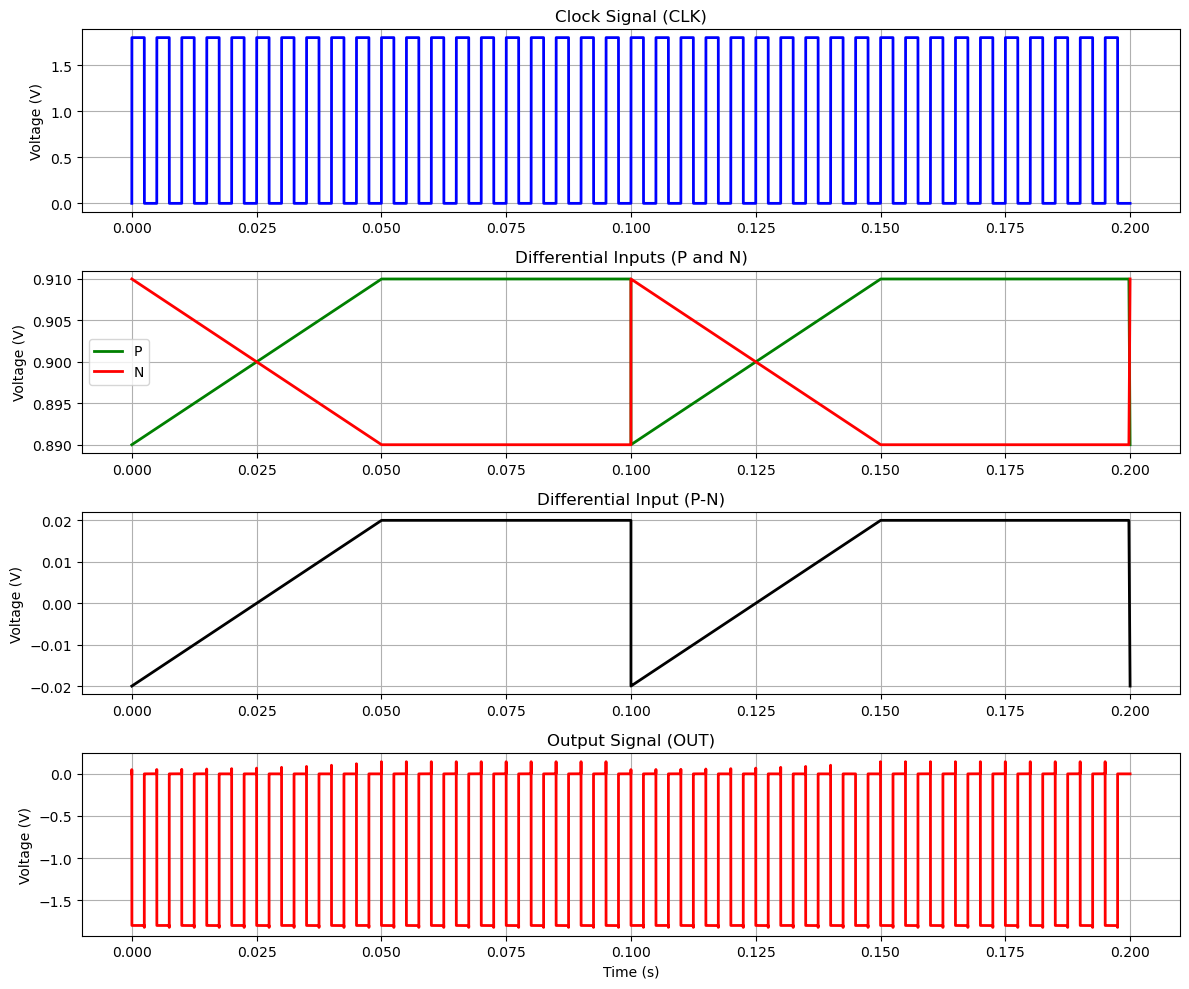

In [15]:
# Create figure with subplots
plt.figure(figsize=(12, 10))

# Plot CLK signal
plt.subplot(4, 1, 1)
plt.plot(time, v_clk, 'b-', linewidth=2)
plt.title('Clock Signal (CLK)')
plt.ylabel('Voltage (V)')
plt.grid(True)

v_diff = v_p - v_n
# Plot P and N signals
plt.subplot(4, 1, 2)
plt.plot(time, v_p, 'g-', linewidth=2, label='P')
plt.plot(time, v_n, 'r-', linewidth=2, label='N')
plt.title('Differential Inputs (P and N)')
plt.ylabel('Voltage (V)')
plt.grid(True)
plt.legend()

# Plot differential input (P-N)
plt.subplot(4, 1, 3)
plt.plot(time, v_diff, 'k-', linewidth=2)
plt.title('Differential Input (P-N)')
plt.ylabel('Voltage (V)')
plt.grid(True)

v_out = v_out_p - v_out_n
# Plot OUT signal
plt.subplot(4, 1, 4)
plt.plot(time, v_out, 'r-', linewidth=2)
plt.title('Output Signal (OUT)')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.grid(True)

plt.tight_layout()
plt.show()

# TODO
1.  Transient Analysis
2.  DC Offset Voltage Analysis
3.  CMRR Analysis
4.  Timing & Speed Analysis
5.  Power Consumption Analysis
6.  Resolution Analysis
7.  Kickback Noise Analysis
8.  PVT Corner Analysis

# DC Offset Voltage Analysis

## Generate TB File

## Ngspice

## Raw Data Processing w/ Spyci 

## Visualizations